# Diamonds Data: Regression Analysis

Author: Ralph Parlin

This project uses ApacheSpark to explore a diamonds dataset using spark pipelines, linear regression, feature transformation, model scoring, inference, and feature selection.

The diamonds.csv data set contains 10 columns:

    carat: Carat weight of the diamond
    cut: Describes cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal
    color: Color of the diamond, with D being the best and J the worst
    clarity: How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, etc. See this web site for an exhaustive ranking of clarity. The web site has a nice sliding scale you can drag to see the relationship between clarity grades.
    depth: depth % - The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
    table: table% - The width of the diamond's table expressed as a percentage of its average diameter
    price: The price of the diamond
    x: Length (mm)
    y: Width (mm)
    z: Height (mm)

## Create the Environment
Note, if you don't have spark, run this file in DataBricks or Colab.  Both of those resources will run the distributed clusters.

In [50]:
# Only Run this is you are using Colab
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./diamonds.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Rparlin/DS_Projects/main/Diamonds_Regression_and_Random_Forest/diamonds.csv 
   
fi

SyntaxError: invalid syntax (<ipython-input-50-442bfd8afa6f>, line 6)

In [4]:
# grading import statements
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

## Read the diamonds.csv file into a spark data frame named diamonds_df.

In [6]:
# Define a function to determine if we running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "dbfs:/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [7]:
# Read in file name
file_name_to_load = get_training_filename("diamonds.csv")

In [8]:
#validate file name
file_name_to_load

'diamonds.csv'

In [9]:
# Read in the data
diamonds_df = spark.read.option("inferSchema", "true").option("header", "true").csv(file_name_to_load)

In [10]:
#Inspect the import
display(diamonds_df .toPandas().head())

,_c0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## EDA / Investigation of the diamond data. 

In [11]:
# EDA: Dimension Inspection
from pyspark.sql import functions as fn # import functions
print("Number of Observations:",diamonds_df.count())
print("Number of Columns:",len(diamonds_df.columns))
print("Number of Columns with real data (less the index column):",(len(diamonds_df.columns)-1))

Number of Observations: 53940
Number of Columns: 11
Number of Columns with real data (less the index column): 10


In [12]:
# Drop the index column
drop_col = ["_c0"]
diamonds_df = diamonds_df.drop(*drop_col)

In [13]:
# EDA: Data Type Inspection
diamonds_df

DataFrame[carat: double, cut: string, color: string, clarity: string, depth: double, table: double, price: int, x: double, y: double, z: double]

##### Note: Based on data type inspection, three features (cut, color, clarity) will need to be transformed to numeric data types

In [14]:
# Generate of list of column names for future use
colList = []
colList = diamonds_df.columns
numColList = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
catColList = ['cut', 'color', 'clarity']
print(colList)
print(numColList)
print(catColList)

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
['cut', 'color', 'clarity']


In [15]:
# EDA: Duplicate Data Removal
diamonds_df = diamonds_df.distinct()

In [16]:
# EDA: Missing Values Inspection
from pyspark.sql.functions import isnan, isnull, when, count, col
for i in colList:
    if (diamonds_df.where(fn.isnull(i)).count() >= 1):
        print(i, "Has nulls")
    else:
        print(i, "Has no nulls")

carat Has no nulls
cut Has no nulls
color Has no nulls
clarity Has no nulls
depth Has no nulls
table Has no nulls
price Has no nulls
x Has no nulls
y Has no nulls
z Has no nulls


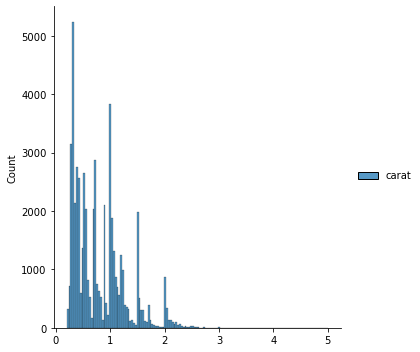

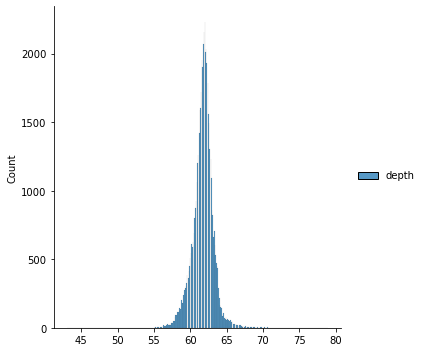

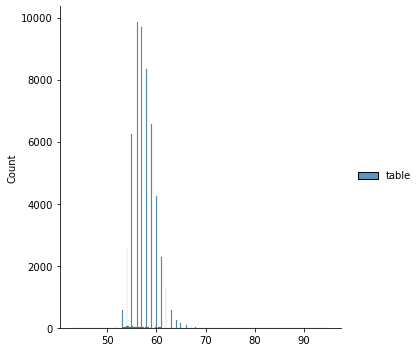

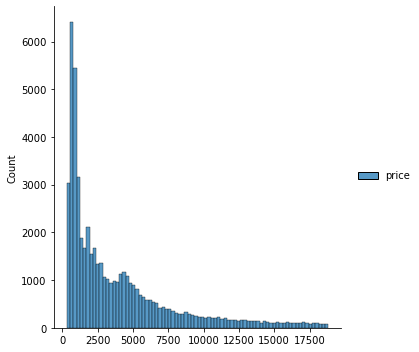

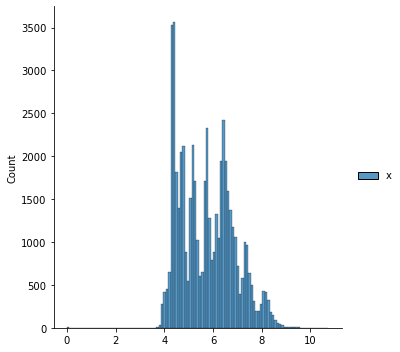

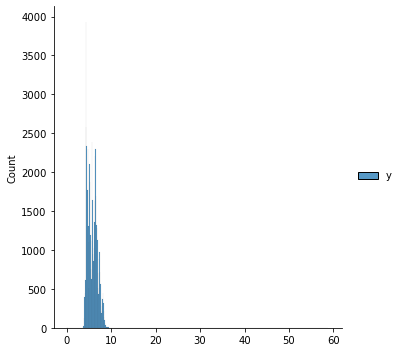

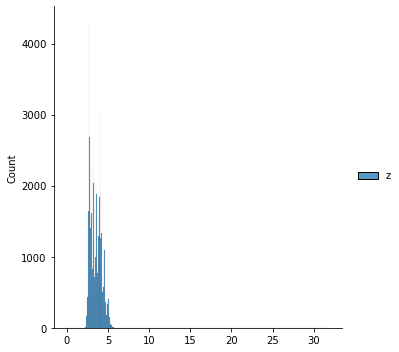

In [17]:
# EDA: Data Distribution Inpsection - Numeric features
import seaborn as sns # Install plotting package
# Create a histogram function (the one in pairplots is too small)
def hist (i):
    for i in numColList:
        column = diamonds_df[i]
        ax = sns.displot(diamonds_df.select(column).toPandas())
    return display(ax)
hist(numColList)

In [18]:
# EDA: Data Distribution Inpsection - Numeric features

#Define a funciton to compute quantiles
def quants(i):
    for i in numColList:
        print("******************* ", i, " *******************")
        print("Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:")
        print("Values    ",diamonds_df.approxQuantile(i, [0.025, 0.25, 0.50, 0.75, 0.975], 0))
        print("")

#Run Function
quants(numColList)

*******************  carat  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [0.28, 0.4, 0.7, 1.04, 2.02]

*******************  depth  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [58.6, 61.0, 61.8, 62.5, 64.4]

*******************  table  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [54.0, 56.0, 57.0, 59.0, 62.0]

*******************  price  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [478.0, 951.0, 2401.0, 5327.0, 15618.0]

*******************  x  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [4.2, 4.71, 5.7, 6.54, 8.12]

*******************  y  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [4.22, 4.72, 5.71, 6.54, 8.11]

*******************  z  *******************
Quantiles [0.025, 0.25, 0.50, 0.75, 0.975]:
Values     [2.58, 2.91, 3.53, 4.03, 5.02]



In [19]:
# EDA: Data Distribution Inpsection - Categorical features

#Define a function to compute Quantity Tables with percent
def table(i):
    for i in catColList:
        print("************ ", i, " **************")
        print("Distribution")
        print(diamonds_df.groupBy(i).count().withColumn("perc_count", (fn.col("count")/diamonds_df.count())*100).sort(fn.col("perc_count")).show())
        print("")
       

table(catColList)

************  cut  **************
Distribution
+---------+-----+-----------------+
|      cut|count|       perc_count|
+---------+-----+-----------------+
|     Fair| 1598|2.970591515782429|
|     Good| 4891|9.092092054876009|
|Very Good|12069|22.43558761200134|
|  Premium|13748|25.55675354128713|
|    Ideal|21488|39.94497527605309|
+---------+-----+-----------------+

None

************  color  **************
Distribution
+-----+-----+------------------+
|color|count|        perc_count|
+-----+-----+------------------+
|    J| 2802| 5.208759341190468|
|    I| 5407|10.051306837193739|
|    D| 6755| 12.55716250882998|
|    H| 8272|15.377179611109046|
|    F| 9520| 17.69714094508681|
|    E| 9776|18.173030449492508|
|    G|11262|20.935420307097445|
+-----+-----+------------------+

None

************  clarity  **************
Distribution
+-------+-----+------------------+
|clarity|count|        perc_count|
+-------+-----+------------------+
|     I1|  740|1.3756180986727145|
|     IF| 17

In [20]:
#Get the value from a sparkDF
val = diamonds_df.agg(fn.avg("price")).sort(fn.col("avg(price)")).head()[0]

In [21]:
# EDA: Data Correlations Inspection (with Target)
from pyspark.ml.stat import Correlation

for i in numColList:
    print(diamonds_df.select(fn.corr('price', i)).show())

+------------------+
|corr(price, carat)|
+------------------+
|0.9215483214030127|
+------------------+

None
+--------------------+
|  corr(price, depth)|
+--------------------+
|-0.01104752186786...|
+--------------------+

None
+-------------------+
| corr(price, table)|
+-------------------+
|0.12656608744342604|
+-------------------+

None
+------------------+
|corr(price, price)|
+------------------+
|               1.0|
+------------------+

None
+------------------+
|    corr(price, x)|
+------------------+
|0.8845040375175459|
+------------------+

None
+------------------+
|    corr(price, y)|
+------------------+
|0.8653952444045167|
+------------------+

None
+------------------+
|    corr(price, z)|
+------------------+
|0.8612077326584755|
+------------------+

None


In [22]:
# EDA: Summary Stats Table 1
print("Let's get a sense of the make-up of the expensive diamonds")
diamonds_df.orderBy("price", ascending=False).show(10)# Let's get a sense of the make-up of the expensive diamonds
print("Diamonds grouped by cut with mean price")
diamonds_df.groupBy("cut").agg(fn.avg("price")).sort(fn.col("avg(price)")).show()
print("Diamonds grouped by color with mean price")
diamonds_df.groupBy("color").agg(fn.avg("price")).sort(fn.col("avg(price)")).show()
print("Diamonds grouped by clarity with mean price")
diamonds_df.groupBy("clarity").agg(fn.avg("price")).sort(fn.col("avg(price)")).show()

Let's get a sense of the make-up of the expensive diamonds
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 2.29|  Premium|    I|    VS2| 60.8| 60.0|18823| 8.5|8.47|5.16|
|  2.0|Very Good|    G|    SI1| 63.5| 56.0|18818| 7.9|7.97|5.04|
| 1.51|    Ideal|    G|     IF| 61.7| 55.0|18806|7.37|7.41|4.56|
| 2.07|    Ideal|    G|    SI2| 62.5| 55.0|18804| 8.2|8.13|5.11|
|  2.0|Very Good|    H|    SI1| 62.8| 57.0|18803|7.95| 8.0|5.01|
| 2.29|  Premium|    I|    SI1| 61.8| 59.0|18797|8.52|8.45|5.24|
| 2.04|  Premium|    H|    SI1| 58.1| 60.0|18795|8.37|8.28|4.84|
|  2.0|  Premium|    I|    VS1| 60.8| 59.0|18795|8.13|8.02|4.91|
| 1.71|  Premium|    F|    VS2| 62.3| 59.0|18791|7.57|7.53| 4.7|
| 2.15|    Ideal|    G|    SI2| 62.6| 54.0|18791|8.29|8.35|5.21|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
only showing top 10 rows

Diamo

Text(0.5, 1.01, 'Daimonds Pair Plot')

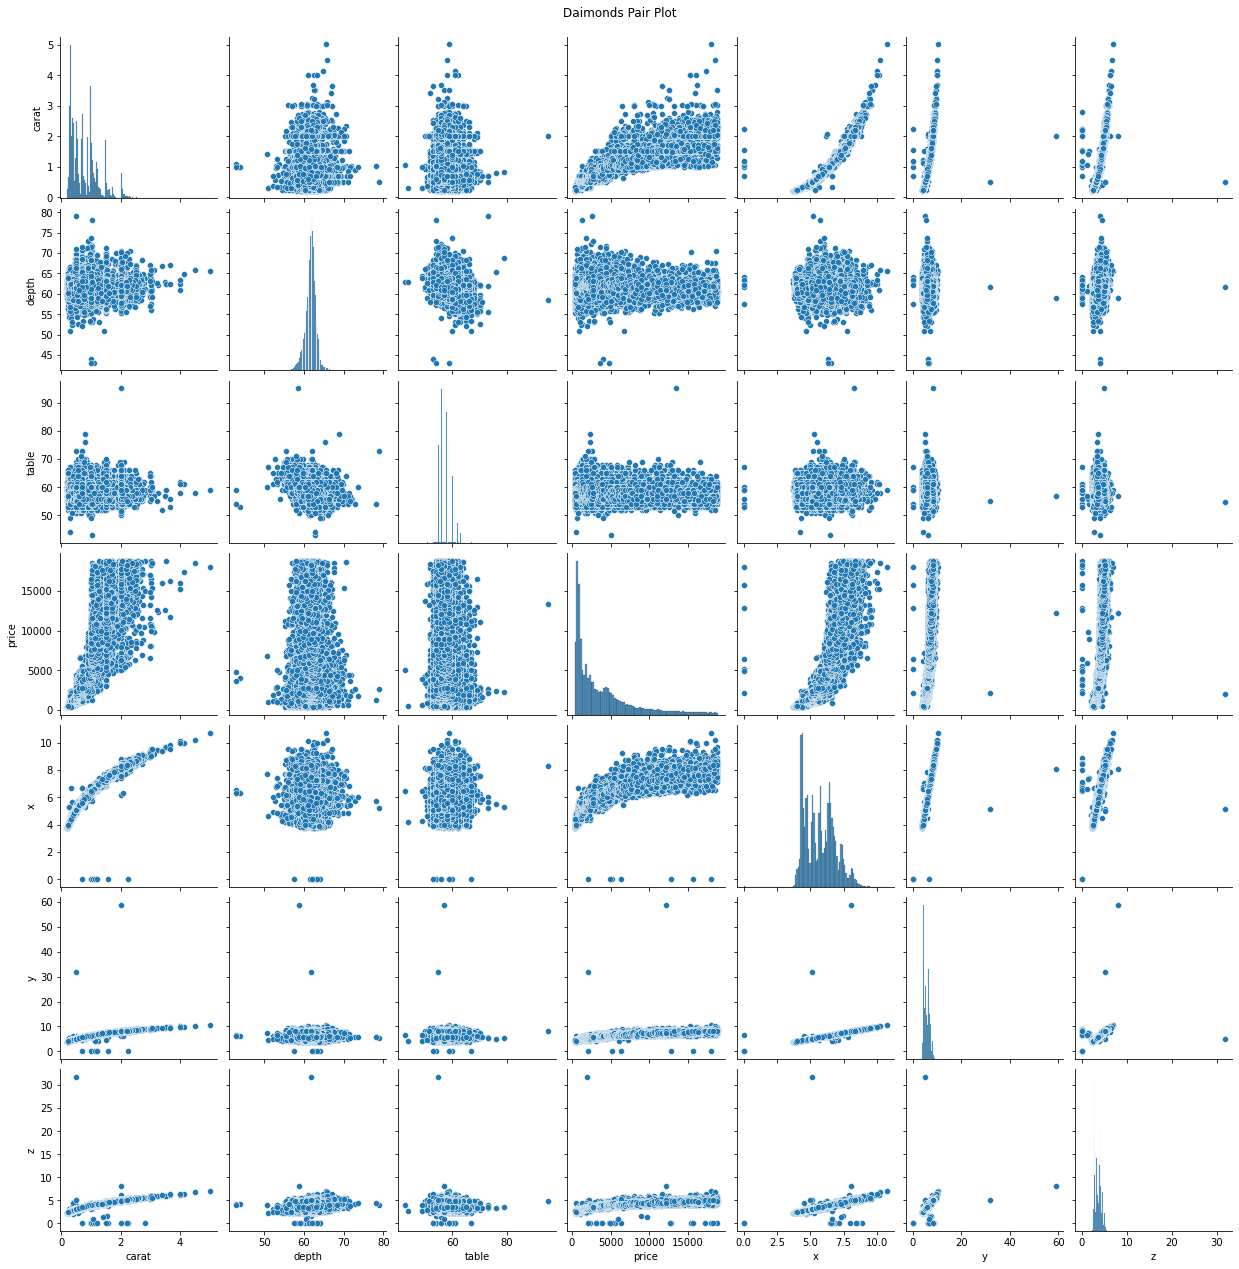

In [23]:
# EDA: Pair Plot Analysis
ax = sns.pairplot(diamonds_df.toPandas())
ax.fig.suptitle("Daimonds Pair Plot", y=1.01)

In [24]:
# EDA: Summary Stats Table 1
dfsummary = diamonds_df.select(numColList).describe()
display(dfsummary.toPandas())

,summary,carat,depth,table,price,x,y,z
0,count,53794,53794,53794,53794,53794,53794,53794
1,mean,0.7977800498196828,61.748079711491975,57.458108711008634,3933.065081607614,5.7312144477079245,5.734653307060267,3.5387136111834034
2,stddev,0.4733902400388433,1.4299091342639072,2.2336790680620906,3988.1144602649592,1.1206947415165147,1.1412091895745784,0.7050374838682583
3,min,0.2,43.0,43.0,326,0.0,0.0,0.0
4,max,5.01,79.0,95.0,18823,10.74,58.9,31.8


In [25]:
# This is another way to review that includes the quartiles
display(diamonds_df.select(numColList).summary().toPandas())

,summary,carat,depth,table,price,x,y,z
0,count,53794,53794,53794,53794,53794,53794,53794
1,mean,0.7977800498196828,61.748079711491975,57.458108711008634,3933.065081607614,5.7312144477079245,5.734653307060267,3.5387136111834034
2,stddev,0.4733902400388433,1.4299091342639072,2.2336790680620906,3988.1144602649592,1.1206947415165147,1.1412091895745784,0.7050374838682583
3,min,0.2,43.0,43.0,326,0.0,0.0,0.0
4,25%,0.4,61.0,56.0,951,4.71,4.72,2.91
5,50%,0.7,61.8,57.0,2401,5.7,5.71,3.53
6,75%,1.04,62.5,59.0,5328,6.54,6.54,4.03
7,max,5.01,79.0,95.0,18823,10.74,58.9,31.8


# EDA Summary
### Diamond Analysis
The diamonds_df dataframe consist of 53940 observation across 10 features: 9 that describe diamond attributes, and 1 that includes price.  The analysis serves to study the features of diamonds and how they relate to price, and will assist with price prediction and inference on how diamond attributes impact price.
This section of the notebook focuses on Exploratory Data Analysis (EDA).  The EDA began with inspecting the data types.  This inspection was performed to become familiar with the data and examone how to treat the features.  We see that there are 7 numeric features, and 3 categorical features.

### Seven Numeric Features Summary and Statistics:
Of the seven numeric features, six are measured dimensions of the diamond, and one is price.  These numeric features include: 
Carat: Diamond carat weight is the measurement of how much a diamond weighs. A metric "carat" is defined as 200 milligrams.  For this feature we see that the mean value is apx. 0.798 with a standard deviation of apx 0.474.  We also see that min value is 0.2, and the max value is 5.01.  This means the range is 4.81.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 0.7, which is less than the mean resulting in a right-skewed distribution.  

Depth: depth % - The height of a diamond, measured from the culet to the table, divided by its average girdle diameter. For this feature we see that the mean value is apx. 61.749 with a standard deviation of apx 1.433.  We also see that min value is 43, and the max value is 79.  This means the range is 43.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 61.8, which is larger than the mean resulting in a slightly left skewed distribution, but as seen in the pairplot, it’s nearly normal in shape.

Table: table% - The width of the diamond's table expressed as a percentage of its average diameter.  For this feature we see that the mean value is apx. 57.457 with a standard deviation of apx 2.234.  We also see that min value is 43, and the max value is 95.  This means the range is 52.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 57, which is less than the mean resulting in a slightly right-skewed distribution, but as seen in the pairplot, it’s nearly normal in shape. 

Price: This is the price of the diamond (target feature).  For this feature we see that the mean value is apx. 3932.80 with a standard deviation of apx 3989.44.  We also see that min value is 326, and the max value is 18823.  This means the range is 18,497.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 2401, which is less than the mean resulting in a right-skewed distribution.

X: The length of the diamond in mm.  For this feature we see that the mean value is apx. 5.73 with a standard deviation of apx 1.122.  We also see that min value is 0, and the max value is 10.74.  This means the range is 10.74.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 5.7, which is less than the mean resulting in a slightly right-skewed distribution, but as seen in the pairplot, it’s nearly normal in shape.  

Y: The width of the diamond in mm.  For this feature we see that the mean value is apx. 5.73 with a standard deviation of apx 1.142.  We also see that min value is 0, and the max value is 58.9.  This means the range is 58.9.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 5.71, which is less than the mean resulting in a slightly right-skewed distribution, but as seen in the pairplot, it’s nearly normal in shape.  

Z: The Height of the diamond in mm.  For this feature we see that the mean value is apx. 3.539 with a standard deviation of apx 0.706.  We also see that min value is 0, and the max value is 31.8.  This means the range is 31.8.   Also, by looking at the median as calculated in the Quants function, we see that the median value is 3.53, which is less than the mean resulting in a slightly right-skewed distribution, but as seen in the pairplot, it’s nearly normal in shape. 

When we review the Pair Plot we see the same thing in graphical form.  Along the diagonal, a review of the numeric features shows that all but price a relatively normal in shape.  As such, I will not conduct any transformations (e.g. log) on these features.  Additionally, the pairplot shows a nice pairwise correlation graph for all of the features.  It looks as though linearity exists between most of the features, most of them show pretty good bivariate normality, and although there are a few cases of outliers, they don’t appear to be too substantial.

### Three Categorical Features Summary and Statistics:
Cut: This is an ordinal feature with 5 levels: Fair, Good, Ideal, Very Good, Premium.  As we can see from the categorical feature data distribution function I made, the distribution of diamonds with respect to cut are overwhelmingly categorized as “Ideal” coming in at 39.9(percent) of the values. followed by “Premium” at 25.55(percent), “Very Good” at 22.43(percent), “Good” at 9(percent), and lastly, “Fair” at just 2.9(percent).  Also, when we group by cut and look at average price, we see that “Premium has the highest average price at 4,583 (dollars), followed by “Fair” at (dollars)4,341, “Very Good” at 3,981(dollars), “Good” at 3,919(dollars) and lastly “Ideal” at an average price of 3,462 (dollars).

Color: This is an ordinal feature with 7 levels: D, E, F, G, H, I, J.  As we can see from the categorical feature data distribution function I made, the distribution of diamonds with respect to color are pretty evenly split with G leading at 20.93 (percent), followed by E at 18.17 (percent), F at 17.69(percent), H at 15.37(percent), D at 12.55(percent), I at 10.05(percent) and lastly, J at 5.20(percent) of the distribution.  Also, when we group by color and look at average price, we see that the although J is has the highest average price of 5,326 (dollars) (which may explain why there are so few of them in the distribution), followed by I at 5,081(dollars), H at 4,482(dollars), G at 4,001(dollars), F at 3,726 (dollars), D at 3,174 (dollars) and lastly, E at 3,079(dollars).

Clarity: This is an ordinal feature with 8 levels: I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF. As we can see from the categorical feature data distribution function I made, the distribution of diamonds with respect to clarity, a majority of the distribution resides in the lower half of the clarity rating scale with SI1 leading at 24.22(percent), followed by VS2 at 22.73(percent), SI2 at 17.01(percent), VS1 at 15.16(percent), VVS2 at 9.39(percent), VVS1 at 6.77(percent), IF at 3.31(percent) and lastly, I1 at 1.37(percent).  Interestingly, the low-end and high-end clarity scales are the tow most uncommon diamonds in the dataset.  I guess no one wants to by the worst, and most likely few can afford the best.  Also when grouped by clarity and we look at the average price, we see that SI2 is the highest with an average price of ($) 5, 057, followed by SI1 at 3,996 (dollars), VS2 at 3,927 (dollars), I1 at 3,925 (dollars), VS1 at 3,841 (dollars), VVS2 at 3,286 (dollars), IF at 2,870 (dollars) and lastly, VVS1 at 2,526 (dollars).


## Feature Engineering

In order to maximize the potential of my model, several columns need to be transformed.  The first are the categorical features: cut, color, and clarity.  Each of these categorical features are currently encoded using an ordinal scale. As a result, retaining their order is important information we do not want to lose and therefore our encoding should reflect the sequence of each of the ordinal features.  As such, we will perform label encoding that preserves this scale.  I used the StringIndexerModel function and used the .from_labels so I could control how the categorical variables were encoded.

Normally in this stage, I would have also have transformed any of the featured with concerning distributions that I learned from my EDA.  However, for this dataset, all but price were close to relative normal distributions so no transformation (e.g. log, etc.) were required.

The only other transformation I would perform in this stage would be to standardize the values across the numeric features.  Standardized scaling helps us compare across columns, and helps us with inference since the importance or magnitude of each feature is standardized in the coefficient values.  However I'll do this step in a later pipeline.

In [26]:
# Create the Pipeline to transform features
from pyspark.ml import feature, regression, evaluation, Pipeline #import modules/packages for the entire process

feature_engineering_pipe = Pipeline(stages=[
                                    feature.StringIndexerModel.from_labels(['D', 'E', 'F', 'G', 'H', 'I', 'J'],
                                        inputCol="color",
                                        outputCol="color_idx"),
                                    feature.StringIndexerModel.from_labels(['Fair', 'Good', 'Ideal', 'Very Good', 'Premium'],
                                        inputCol = "cut",
                                        outputCol = "cut_idx"),
                                    feature.StringIndexerModel.from_labels(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
                                        inputCol = "clarity",
                                        outputCol = "clarity_idx")])

In [27]:
#Execute transformation pipline to create a new dataframe titled diamonds_df_xformed
diamonds_df_xformed = feature_engineering_pipe.fit(diamonds_df).transform(diamonds_df)

In [28]:
# Drop old columns and rename the columns with orginal names as required in the unstructions.
diamonds_df_xformed = diamonds_df_xformed.drop("cut", "color", "clarity")
diamonds_df_xformed = diamonds_df_xformed.withColumnRenamed("cut_idx", "cut")\
.withColumnRenamed("color_idx","color")\
.withColumnRenamed("clarity_idx", "clarity")

## Fit  A Regresison Pipeline

In [29]:
# I'll begin by splitting my data into train and test partitions.  I've decided not to split out a seperate validation set since I will not be comparing models in this phase.
training_diamonds_df_xformed, testing_diamonds_df_xformed = diamonds_df_xformed.randomSplit([0.7, 0.3],0)

In [30]:
# Inspect the split
[training_diamonds_df_xformed.count(), testing_diamonds_df_xformed.count()]

[37592, 16202]

In [31]:
#Create the regression pipline but first scale all features, inlcuding the catagroical features that have been converted to numeric coding.
# I've included the standard scaler in this step, even though its only asked for in in Question 6, becuase I believe
# scaling the data before modeling is a best-practice that I like to follow.
diamond_pipe = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['carat','depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity'], outputCol = 'features'),
    feature.StandardScaler(inputCol="features", outputCol="scaledFeatures"),
    regression.LinearRegression(featuresCol='scaledFeatures', labelCol='price')])

In [32]:
# Fit the regression model on the training data
diamond_pipe_model_fitted = diamond_pipe.fit(training_diamonds_df_xformed)

In [33]:
# Review the work using the training data
display(diamond_pipe_model_fitted.transform(training_diamonds_df_xformed).toPandas().head())

,carat,depth,table,price,x,y,z,color,cut,clarity,features,scaledFeatures,prediction
0,0.23,61.8,55.0,493,3.93,3.96,2.43,2.0,2.0,3.0,"[0.23, 61.8, 55.0, 3.93, 3.96, 2.43, 2.0, 2.0,...","[0.4846272028823745, 43.44462296984456, 24.546...",-378.096324
1,0.24,58.3,57.0,552,4.10,4.14,2.40,2.0,1.0,6.0,"[0.24, 58.3, 57.0, 4.1, 4.14, 2.4, 1.0, 2.0, 6.0]","[0.505697950833782, 40.98416697640676, 25.4392...",1238.741401
2,0.25,60.7,59.0,740,4.10,4.07,2.48,2.0,4.0,6.0,"[0.25, 60.7, 59.0, 4.1, 4.07, 2.48, 4.0, 2.0, ...","[0.5267686987851896, 42.6713368004784, 26.3318...",1252.871646
3,0.28,60.1,59.0,646,4.22,4.26,2.55,1.0,4.0,5.0,"[0.28, 60.1, 59.0, 4.22, 4.26, 2.55, 4.0, 1.0,...","[0.5899809426394125, 42.24954434446049, 26.331...",1345.074314
4,0.28,64.0,56.0,532,4.14,4.17,2.66,0.0,3.0,5.0,"[0.28, 64.0, 56.0, 4.14, 4.17, 2.66, 3.0, 0.0,...","[0.5899809426394125, 44.99119530857689, 24.992...",1466.043789


In [34]:
# Review the work using the testing data
display(diamond_pipe_model_fitted.transform(testing_diamonds_df_xformed).toPandas().head())

,carat,depth,table,price,x,y,z,color,cut,clarity,features,scaledFeatures,prediction
0,0.23,59.9,65.0,439,3.93,3.95,2.36,1.0,1.0,6.0,"[0.23, 59.9, 65.0, 3.93, 3.95, 2.36, 1.0, 1.0,...","[0.4846272028823745, 42.10894685912118, 29.009...",912.237803
1,0.25,61.7,56.0,705,4.06,4.07,2.51,2.0,2.0,5.0,"[0.25, 61.7, 56.0, 4.06, 4.07, 2.51, 2.0, 2.0,...","[0.5267686987851896, 43.37432422717491, 24.992...",694.110324
2,0.30,60.7,58.0,789,4.34,4.36,2.64,3.0,4.0,6.0,"[0.3, 60.7, 58.0, 4.34, 4.36, 2.64, 4.0, 3.0, ...","[0.6321224385422275, 42.6713368004784, 25.8855...",1330.974299
3,0.30,62.5,54.0,573,4.29,4.32,2.69,2.0,2.0,3.0,"[0.3, 62.5, 54.0, 4.29, 4.32, 2.69, 2.0, 2.0, ...","[0.6321224385422275, 43.93671416853212, 24.100...",69.863582
4,0.30,62.5,57.0,491,4.26,4.29,2.67,4.0,2.0,3.0,"[0.3, 62.5, 57.0, 4.26, 4.29, 2.67, 2.0, 4.0, ...","[0.6321224385422275, 43.93671416853212, 25.439...",-752.827968


## Create an Evaluator Pipeline

In [35]:
#Create the evaluator with metric set to MSE
from pyspark.ml.evaluation import RegressionEvaluator # bring in the Regression Evaluator module
diamond_pipe_evaluator = RegressionEvaluator()\
.setMetricName("mse")\
.setPredictionCol("prediction")\
.setLabelCol("price") # assing y

In [36]:
print("Train data MSE :",  diamond_pipe_evaluator.evaluate(diamond_pipe_model_fitted.transform(training_diamonds_df_xformed)))
print("Test data MSE :",  diamond_pipe_evaluator.evaluate(diamond_pipe_model_fitted.transform(testing_diamonds_df_xformed)))

Train data MSE : 1504826.673040201
Test data MSE : 1426767.5259783675


## Conduct another pipline but this time use Cross Validation (with an empty parameter grid)

In [37]:
# Create a Cross Fold function to the evaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
params =  ParamGridBuilder().build() # build an empty parameter grid

cv = CrossValidator()\
    .setEstimator(diamond_pipe)\
    .setEvaluator(diamond_pipe_evaluator)\
    .setEstimatorParamMaps(params)\
    .setNumFolds(3)

In [38]:
final_model_fitted = cv.fit(diamonds_df_xformed)# Fit the compelte data set and let it conduct it partitioning of test/train across the folds

In [39]:
# Let's see how our 3 fold cross validation fold did with repect to the training data 
print("The resulting score from 3-folds cross validation on training data with empty parameters is : ", final_model_fitted.avgMetrics)

The resulting score from 3-folds cross validation on training data with empty parameters is :  [1483529.0048332263]


In [40]:
# Let's see how our 3 fold cross validation fold did with repect to the testing data 
print("The resulting score from 3-folds cross validation on testing data with empty parameters is : " , diamond_pipe_evaluator.evaluate(final_model_fitted.transform(testing_diamonds_df_xformed)))

The resulting score from 3-folds cross validation on testing data with empty parameters is :  1424495.8644346932


The scoring technique built with the evaluation pipeline for Regression Evaluation compared the prediction versus the target column price to calculate the MSE on a model fit with training data. The evaluator optimizes and then trains our pipeline to perform tuning in support of the desired metric. The evaluator allows us to compare models automatically and objectively to the same evaluation metric providing us a sense on how the model preformed on unseen data. I ran the training data through the evaluator, and also ran the test data through the evaluator. As such, I got an evaluation on how well the fitted model performed with respect to MSE on the test data.

With respect to cross validation, it is a special case of the holdout method we did earlier, but it uses the average result from several random holdout samples to evaluate a model’s performance. This “multiple holdout sample” method helps ensure our model is trained and tested on representative data. Rather than taking repeated samples that may or may not have the same record one, twice, or more times, k-folds CV divides the data into k completely randomly split partitions called folds—hence the name. In this case we had 3 folds so it partitions the dataset into test and train for 3 folds. Normally, in machine learning the best practice is to fit hyperparameters on a validation set (instead of our test data) to prevent overfitting. As such, we should not use our hold-out data (test) to tune parameters. However, in our case, we have an empty parameter so there will be no tuning, only a performance assessment. As such we fit the CV with the entire dataset and we can see that through variations of train/split folds, we were about to fit a model that produced a lower MSEs.

## Inference

In [41]:
# My inference pipe is very similiar to my diamond pipe becuase I chose to scale my data earlier in this process.
inference_pipe = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['carat','depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity'], outputCol = 'features'),
    feature.StandardScaler(inputCol="features", outputCol="scaledFeatures"),
    regression.LinearRegression(featuresCol='scaledFeatures', labelCol='price')])

In [42]:
inference_pipe_model_fitted = inference_pipe.fit(testing_diamonds_df_xformed)
print("Coefficients: " + str(inference_pipe_model_fitted.stages[-1].coefficients))
print("Intercept: " + str(inference_pipe_model_fitted.stages[-1].intercept))

Coefficients: [5192.190043669851,-150.90321809677758,-144.83484092611874,-1354.6712340254412,258.84486724668295,0.05367731363114906,104.1560393870408,-544.7217861860807,823.3496536802935]
Intercept: 9997.366289554266


In [43]:
CoeffListNames =['carat','depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']

In [44]:
CoeffListVales = inference_pipe_model_fitted.stages[-1].coefficients

In [45]:
import pandas as pd
coefficients_df = pd.DataFrame(list(zip(CoeffListNames, CoeffListVales)), #zip the values together and move to a DF
               columns =['coefficient', 'value'])
coefficients_df['value'] = coefficients_df['value'].abs() #output in absolute value as instructed
display(coefficients_df) # check the work

,coefficient,value
0,carat,5192.190044
1,depth,150.903218
2,table,144.834841
3,x,1354.671234
4,y,258.844867
5,z,0.053677
6,cut,104.156039
7,color,544.721786
8,clarity,823.349654


Although many machine learners require the standardization of data, in our case with linear regression, scaling the data is not required.  That said, standardization can be very helpful, particularly when modeled variables are of different units, but also with respect to inference.  By using the StandardizedScaler to standardizing our features and then modeling, we gain inference by directly comparing the absolute value of the resulting model coefficients against each other to see which coefficient is more important (makes a bigger impact) on the outcome.  The standardization gives a better sense of the magnitude each coefficient has in explaining the variability in the dependent variable, by putting standardizing the units to standard deviations to help us see relative importance of each variable among the other variables.  The higher the absolute value of the beta coefficient, the stronger the effect each independent variable has the dependent variable (in the presence of the other variables – key note!).   As seen in our data frame above, we have coefficients that impact price in a positive and negative way, which is based on there sign.  If we only consider the absolute values, we see that when all of the features are in the model, carat has the greatest impact on price.  This can be interpreted as, holding all other variables constant, for every increase of one standard deviation caret, a diamonds price income rises by 1 standard deviation, price would increase $5,192.

## Partial Stepwise Custom Fuction
The fucntion below will perform a partial stepwise function that I will use nested into a complete stepwise procedure later

In [46]:
#Clean with error for empty initial Columns
def find_best_pred(initialCols,improveCols,targetCol):
    coefTitleHold = [] # create empty container
    coefValHold = [] # create empty container
    vec = 0 # check to make sure there are no duplicate column untries in teh initialCols and improveCols
    for n in initialCols: # test to make sure the same columns are not listed in both arguements
        for j in improveCols:
            if n == j:
                vec = vec + 1
                if vec > 0:
                    return print("Please check your entry, you have similiar columns listed in the inital and improve column lists")
    if len(improveCols) == 0: # test to check if the improveCols is an empty set, in which case, they would not improve MSE and we should print "NULL"
        return "Null"
    if len(initialCols) == 0: # test to see if the arguement for initialCols was an empty set, and if so, the NUll model cycles through the improve cols to see which one has best improvement on MSE
        for i in improveCols: # iteration to develop teh initial model by finding the best initial predictor if no initialCols were provided
            pipe = Pipeline(stages=[
                feature.VectorAssembler(inputCols= [i], outputCol = 'features'),
                feature.StandardScaler(inputCol="features", outputCol="scaledFeatures"),
                regression.LinearRegression(featuresCol='scaledFeatures', labelCol=targetCol)])
            lr_model_fit = pipe.fit(training_diamonds_df_xformed) # fit on the training data
            eval_pipe = RegressionEvaluator()\
                    .setMetricName("mse")\
                    .setPredictionCol("prediction")\
                    .setLabelCol(targetCol)
            coefTitleHold.append(i) #append the column name        
            coefValHold.append(eval_pipe.evaluate(lr_model_fit.transform(testing_diamonds_df_xformed))) # record MSE from test data
        resultDF = pd.DataFrame(list(zip(coefTitleHold, coefValHold)),columns = ["coeff", "value"])# Zip the lists
        resultDF = resultDF.sort_values(by = ["value"]) # sort to find minium MSE
        MSE = resultDF.iloc[0,1] # Take minimum MSE value
        bestCol = resultDF.iloc[0,0] # TAke column name that provided minimum MSE value
        print("No intial columns were provided, but after conducting a stepwise through the improvement columns", improveCols, "the '",bestCol,"' column provided the largest improvement (reduction) resulting in an MSE of", MSE)
        return bestCol 
    # If an empty set was not passed as the first arguement, the function must now fit the input columns, and
    # and then stepwise through the input columns to determine if an improvement to MSE happens, and if so, which column
    # lead to the improvement.
    
    #Create intial model and record its MSE
    pipe = Pipeline(stages=[ # create pipe
                feature.VectorAssembler(inputCols = initialCols, outputCol = 'features'),
                feature.StandardScaler(inputCol="features", outputCol="scaledFeatures"),
                regression.LinearRegression(featuresCol='scaledFeatures', labelCol=targetCol)])
    lr_model_fit = pipe.fit(training_diamonds_df_xformed) # fit on the training data
    eval_pipe = RegressionEvaluator()\
                    .setMetricName("mse")\
                    .setPredictionCol("prediction")\
                    .setLabelCol(targetCol)
    MSE = eval_pipe.evaluate(lr_model_fit.transform(testing_diamonds_df_xformed)) # evaluate the test data
    
    for i in improveCols: #Iterate through improve columns as part of the intial model to ID which var reduces MSE the most
        pipe = Pipeline(stages=[
            feature.VectorAssembler(inputCols= [i]+initialCols, outputCol = 'features'),
            feature.StandardScaler(inputCol="features", outputCol="scaledFeatures"),
            regression.LinearRegression(featuresCol='scaledFeatures', labelCol=targetCol)])
        lr_model_fit = pipe.fit(training_diamonds_df_xformed) # fit on the training data
        eval_pipe = RegressionEvaluator()\
                    .setMetricName("mse")\
                    .setPredictionCol("prediction")\
                    .setLabelCol(targetCol)
        MSE_New = eval_pipe.evaluate(lr_model_fit.transform(testing_diamonds_df_xformed))# evaluate the test data
        coefTitleHold.append(i) # append each column name       
        coefValHold.append(eval_pipe.evaluate(lr_model_fit.transform(testing_diamonds_df_xformed))) # record MSE from the model with each predictor one at a time
    resultDF = pd.DataFrame(list(zip(coefTitleHold, coefValHold)),columns = ["coeff", "value"]) # zip the lists into a DF
    resultDF = resultDF.sort_values(by = ["value"]) # sort to find lowest value
    MSE_New = resultDF.iloc[0,1] # select lowest value MSE
    bestCol = resultDF.iloc[0,0] # sleect lowest value MSE column name
    if MSE <= MSE_New: # If the initial input columns yeild the lowest MSE print NULL, otherwise indicate which column made the improvement
        return "Null"       
    print("The original model with the following columns:", initialCols, "provided an MSE of", MSE)
    print("After conducting a stepwise through the improvement columns", improveCols, "the '",bestCol,"' column provided the largest improvement (reduction) to the base model.")
    print("After the stepwise procedure, the new MSE is", MSE_New)
    return bestCol


In [47]:
# Test cell of the function
print(find_best_pred([], ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))
print(find_best_pred(['carat', 'cut'], ['color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

No intial columns were provided, but after conducting a stepwise through the improvement columns ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'] the ' carat ' column provided the largest improvement (reduction) resulting in an MSE of 2316520.6942543876
carat
The original model with the following columns: ['carat', 'cut'] provided an MSE of 2309189.808871975
After conducting a stepwise through the improvement columns ['color', 'clarity', 'depth', 'table', 'x', 'y', 'z'] the ' clarity ' column provided the largest improvement (reduction) to the base model.
After the stepwise procedure, the new MSE is 1758065.3641550823
clarity


## Complete Stepwise Custom Function

In [48]:
#My Stepwise function

def get_stepwise_pred_list(predictionList,targetCol):
    coefTitleHold = [] # set empty container
    coefValHold = [] # set empty container
    initialCols = [] # set empty container
    improveCols = predictionList # rename to fit function
    
    vec = 0 # check data entry into function call
    if len(predictionList) == 0:
        return print("Please check your entry, you have not entered any prediciton columns.")
    if len(targetCol) == 0: 
        return print("Please check your entry, you have not entered a target column.")
    
    #Create a base model to pass to find_best_pred
    for i in predictionList: 
        pipe = Pipeline(stages=[
            feature.VectorAssembler(inputCols= [i], outputCol = 'features'),
            feature.StandardScaler(inputCol="features", outputCol="scaledFeatures"),
            regression.LinearRegression(featuresCol='scaledFeatures', labelCol=targetCol)])
        lr_model_fit = pipe.fit(training_diamonds_df_xformed) # fit on the training data
        eval_pipe = RegressionEvaluator()\
                .setMetricName("mse")\
                .setPredictionCol("prediction")\
                .setLabelCol(targetCol)
        coefTitleHold.append(i)  # Append each column name      
        coefValHold.append(eval_pipe.evaluate(lr_model_fit.transform(testing_diamonds_df_xformed))) # record MSE from test data
    resultDF = pd.DataFrame(list(zip(coefTitleHold, coefValHold)),columns = ["coeff", "value"]) # zip and move to DF
    resultDF = resultDF.sort_values(by = ["value"]) # sort to find minimum value
    MSE = resultDF.iloc[0,1] # Assign minimum value to MSE
    bestCol = resultDF.iloc[0,0] # record column name that provided minimum MSE value
        # at this stage, best call is now the first imput into_find_best_pred (initalCols)
        # and whatever was selected for bestCol, must now be removed from predictionList
    initialCols.append(bestCol) # update containers with winning column
    improveCols.remove(bestCol) # update improveCols by removing the column that got selected in previous step
    print("The first variable to join the model is:", bestCol)
    print("Now we'll run the remaining columns one by one to see which and when they enter.  The remaining columns are: ",improveCols)
    print("******************************")
    # Run through best pred 
        
    while len(improveCols)> 0:
        newCol = find_best_pred(initialCols,improveCols,targetCol)
        #print(newCol, "has been selected as the variable that lowered MSE the most!")
        if newCol == "Null":
            print("Reached the lowest MSE, will not accept any other columns.  Here are the stepwise columns:" )
            return initialCols
        initialCols.append(newCol)# update containers with winning column
        improveCols.remove(newCol) # update improveCols by removing the column that got selected in previous step    
        print("*****************************")
    return initialCols

In [49]:
# Let's see how it progesses through this list of features.
print(get_stepwise_pred_list(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

The first variable to join the model is: carat
Now we'll run the remaining columns one by one to see which and when they enter.  The remaining columns are:  ['cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
******************************
The original model with the following columns: ['carat'] provided an MSE of 2316520.6942543876
After conducting a stepwise through the improvement columns ['cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'] the ' clarity ' column provided the largest improvement (reduction) to the base model.
After the stepwise procedure, the new MSE is 1767512.9575336713
*****************************
The original model with the following columns: ['carat', 'clarity'] provided an MSE of 1767512.9575336713
After conducting a stepwise through the improvement columns ['cut', 'color', 'depth', 'table', 'x', 'y', 'z'] the ' color ' column provided the largest improvement (reduction) to the base model.
After the stepwise procedure, the new MSE is 1507036.